# Setup


In [1]:
IS_FIRST_COLUMN_INDEX = False


# Embeddings catalog


In [2]:
from config import (
    EMBEDEDINGS_FILEPATH_Mini_LML6_v2,
    EMBEDEDINGS_FILEPATH_mpnet_base_v2,
    EMBEDEDINGS_FILEPATH_open_ai_api,
    EMBEDEDINGS_FILEPATH_tf_idf_bigrams,
    EMBEDEDINGS_FILEPATH_tf_idf_monograms,
)

EMBEDDING_SOURCES = {
    "MiniLM-L6-v2": EMBEDEDINGS_FILEPATH_Mini_LML6_v2,
    "mpnet-base-v2": EMBEDEDINGS_FILEPATH_mpnet_base_v2,
    "OpenAI-API": EMBEDEDINGS_FILEPATH_open_ai_api,
    "TF-IDF bigrams": EMBEDEDINGS_FILEPATH_tf_idf_bigrams,
    "TF-IDF monograms": EMBEDEDINGS_FILEPATH_tf_idf_monograms,
}

embedding_order_all = list(EMBEDDING_SOURCES.keys())


# Data loading helper


In [3]:
from config import load_embeddings_and_data


def load_embedding_dataset(embedding_path, csv_path, is_first_column_index=False):
    # CSV_FILEPATH_MODEL_READY_DATA has no explicit index column
    return load_embeddings_and_data(
        embeddings_filepath=embedding_path,
        csv_filepath=csv_path,
        isFirstColumnIndex=is_first_column_index,
        check_length=True,
    )


# Feature preparation


In [4]:
def prepare_features(df, target_col, vintage_col="vintage"):
    df = df.copy()

    y = df[target_col]
    X = df.drop(columns=[target_col])

    # Keep numeric features only (all model-ready features are numeric)
    X = X.select_dtypes(include="number")

    # Embedding columns are integers (0..N-1) after concatenation
    base_cols = [c for c in X.columns if not isinstance(c, int)]
    emb_cols = [c for c in X.columns if isinstance(c, int)]

    # sklearn requires uniform (string) feature names
    X.columns = X.columns.astype(str)
    base_cols = [str(c) for c in base_cols]
    emb_cols = [str(c) for c in emb_cols]

    return X, y, base_cols, emb_cols


# Preprocessing pipelines


In [5]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer


def build_preprocessor_all_features():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ])


def build_preprocessor_with_polynomial(base_cols, emb_cols, degree=2):
    # Apply polynomial only to base features to keep feature count manageable
    transformers = []

    if base_cols:
        base_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("poly", PolynomialFeatures(degree=degree, include_bias=False)),
            ("scaler", StandardScaler()),
        ])
        transformers.append(("base", base_pipeline, base_cols))

    if emb_cols:
        emb_pipeline = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ])
        transformers.append(("emb", emb_pipeline, emb_cols))

    return ColumnTransformer(transformers, remainder="drop")


# Regression models catalog


In [6]:
from config import RANDOM_STATE
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet


def get_regression_builders():
    return {
        "Linear": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", LinearRegression()),
        ]),
        "Ridge": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
        ]),
        "Lasso": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", Lasso(alpha=0.001, max_iter=10000, random_state=RANDOM_STATE)),
        ]),
        "ElasticNet": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_all_features()),
            ("model", ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10000, random_state=RANDOM_STATE)),
        ]),
        "PolynomialRidge(deg2)": lambda base_cols, emb_cols: Pipeline([
            ("preprocess", build_preprocessor_with_polynomial(base_cols, emb_cols, degree=2)),
            ("model", Ridge(alpha=1.0, random_state=RANDOM_STATE)),
        ]),
    }

regression_builders = get_regression_builders()
regression_order_all = list(regression_builders.keys())


## Experiment selection


In [7]:
from config import (
    CSV_FILEPATH_MODEL_READY_DATA_POINTS_FILLED,
    CSV_FILEPATH_MODEL_READY_DATA_PRICE_FILLED,
)

# Choose a subset (None = all)
# ACTIVE_EMBEDDINGS = None
ACTIVE_EMBEDDINGS = [
    # "MiniLM-L6-v2",
    "mpnet-base-v2",
    "OpenAI-API",
    "TF-IDF bigrams",
    # "TF-IDF monograms",
]

# ACTIVE_REGRESSIONS = None
ACTIVE_REGRESSIONS = [
    # "Linear",
    "Ridge",
    # "Lasso",
    # "ElasticNet",
    "PolynomialRidge(deg2)",
]

# ACTIVE_TARGETS = ["points", "price"]
ACTIVE_TARGETS = [
    "points",
    "price",
]

SHOW_PROGRESS = True
# SHOW_PROGRESS = False

TEST_SIZE = 0.2

TARGET_CONFIG = {
    "points": {
        "target_col": "points",
        "csv_path": CSV_FILEPATH_MODEL_READY_DATA_POINTS_FILLED,
    },
    "price": {
        "target_col": "price",
        "csv_path": CSV_FILEPATH_MODEL_READY_DATA_PRICE_FILLED,
    },
}


def select_dict_subset(source_dict, active_keys):
    if active_keys is None:
        return source_dict
    missing = [k for k in active_keys if k not in source_dict]
    if missing:
        raise ValueError(f"Missing keys: {missing}")
    return {k: source_dict[k] for k in active_keys}


def select_targets(active_targets):
    if active_targets is None:
        return list(TARGET_CONFIG.keys())
    missing = [t for t in active_targets if t not in TARGET_CONFIG]
    if missing:
        raise ValueError(f"Missing targets: {missing}")
    return active_targets


TARGETS = select_targets(ACTIVE_TARGETS)
EMBEDDING_SOURCES_ACTIVE = select_dict_subset(EMBEDDING_SOURCES, ACTIVE_EMBEDDINGS)
regression_builders_active = select_dict_subset(regression_builders, ACTIVE_REGRESSIONS)

embedding_order = list(EMBEDDING_SOURCES_ACTIVE.keys())
regression_order = list(regression_builders_active.keys())


To add new embeddings, extend `EMBEDDING_SOURCES`.
To add new regressions, extend `get_regression_builders()` with a new entry.


# Metrics and evaluation helpers


In [8]:
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
METRICS = ["R2", "MAE", "MSE", "RMSE", "MAPE", "FitTimeSec"]


def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return {
        "R2": r2_score(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MSE": mse,
        "RMSE": np.sqrt(mse),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
    }


def evaluate_models_for_embedding(
    df,
    embedding_name,
    builders,
    target_col,
    show_progress=True,
    progress=None,
    target_name=None,
):
    X, y, base_cols, emb_cols = prepare_features(df, target_col=target_col)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    results = []
    predictions = {}

    for reg_name, build_model in builders.items():
        label = f"{embedding_name} | {reg_name}"
        if target_name:
            label = f"{target_name} | {label}"

        if progress is not None:
            progress["done"] += 1
            if show_progress:
                print(f"[{progress['done']}/{progress['total']}] {label}")
        elif show_progress:
            print(label)

        model = build_model(base_cols, emb_cols)
        start = time.perf_counter()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        fit_time = time.perf_counter() - start

        metrics = compute_metrics(y_test, y_pred)
        results.append({
            "embedding": embedding_name,
            "regression": reg_name,
            **metrics,
            "FitTimeSec": fit_time,
        })
        predictions[(embedding_name, reg_name)] = (y_test, y_pred)

    return results, predictions


def run_all_experiments(
    embedding_sources,
    builders,
    target_col,
    csv_path,
    show_progress=True,
    target_name=None,
):
    all_results = []
    all_predictions = {}

    progress = {
        "done": 0,
        "total": len(embedding_sources) * len(builders),
    }
    if show_progress:
        if target_name:
            print(f"Target: {target_name}")
        print(f"Total combinations: {progress['total']}")

    for embedding_name, embedding_path in embedding_sources.items():
        if show_progress:
            print(f"Loading: {embedding_name}")
        df = load_embedding_dataset(embedding_path, csv_path)
        results, preds = evaluate_models_for_embedding(
            df,
            embedding_name,
            builders,
            target_col=target_col,
            show_progress=show_progress,
            progress=progress,
            target_name=target_name,
        )
        all_results.extend(results)
        all_predictions.update(preds)

    return pd.DataFrame(all_results), all_predictions


# Run the full experiment suite


In [9]:
results_by_target = {}
predictions_cache = {}

for target_name in TARGETS:
    cfg = TARGET_CONFIG[target_name]
    results_t, preds_t = run_all_experiments(
        EMBEDDING_SOURCES_ACTIVE,
        regression_builders_active,
        target_col=cfg["target_col"],
        csv_path=cfg["csv_path"],
        show_progress=SHOW_PROGRESS,
        target_name=target_name,
    )
    results_t["target"] = target_name
    results_by_target[target_name] = results_t
    predictions_cache[target_name] = preds_t

results_df = pd.concat(results_by_target.values(), ignore_index=True)
results_df


Target: points
Total combinations: 6
Loading: mpnet-base-v2
[1/6] points | mpnet-base-v2 | Ridge
[2/6] points | mpnet-base-v2 | PolynomialRidge(deg2)
Loading: OpenAI-API
[3/6] points | OpenAI-API | Ridge
[4/6] points | OpenAI-API | PolynomialRidge(deg2)
Loading: TF-IDF bigrams
[5/6] points | TF-IDF bigrams | Ridge
[6/6] points | TF-IDF bigrams | PolynomialRidge(deg2)
Target: price
Total combinations: 6
Loading: mpnet-base-v2
[1/6] price | mpnet-base-v2 | Ridge
[2/6] price | mpnet-base-v2 | PolynomialRidge(deg2)
Loading: OpenAI-API
[3/6] price | OpenAI-API | Ridge
[4/6] price | OpenAI-API | PolynomialRidge(deg2)
Loading: TF-IDF bigrams
[5/6] price | TF-IDF bigrams | Ridge
[6/6] price | TF-IDF bigrams | PolynomialRidge(deg2)


,embedding,regression,R2,MAE,MSE,RMSE,MAPE,FitTimeSec,target
0,mpnet-base-v2,Ridge,0.719621,1.276108,2.628663,1.621315,0.014433,12.752826,points
1,mpnet-base-v2,PolynomialRidge(deg2),0.731155,1.239266,2.520527,1.587617,0.014019,26.194803,points
2,OpenAI-API,Ridge,0.777104,1.138116,2.089732,1.445590,0.012870,23.479061,points
3,OpenAI-API,PolynomialRidge(deg2),0.781985,1.109314,2.043976,1.429677,0.012546,40.300821,points
4,TF-IDF bigrams,Ridge,0.673755,1.369104,3.058676,1.748907,0.015486,1.775005,points
5,TF-IDF bigrams,PolynomialRidge(deg2),0.686739,1.325112,2.936940,1.713750,0.014992,12.924558,points
6,mpnet-base-v2,Ridge,0.366207,13.223597,1054.596790,32.474556,0.440058,9.370951,price
7,mpnet-base-v2,PolynomialRidge(deg2),0.514257,11.380272,808.250860,28.429753,0.359921,25.520465,price
8,OpenAI-API,Ridge,0.372909,13.410352,1043.445625,32.302409,0.450839,24.608085,price
9,OpenAI-API,PolynomialRidge(deg2),0.515947,11.533283,805.438754,28.380253,0.369751,48.637356,price


## Timing summary


In [10]:
# Longest combinations (fit + predict)
results_df.sort_values("FitTimeSec", ascending=False).head(10)

,embedding,regression,R2,MAE,MSE,RMSE,MAPE,FitTimeSec,target
9,OpenAI-API,PolynomialRidge(deg2),0.515947,11.533283,805.438754,28.380253,0.369751,48.637356,price
3,OpenAI-API,PolynomialRidge(deg2),0.781985,1.109314,2.043976,1.429677,0.012546,40.300821,points
1,mpnet-base-v2,PolynomialRidge(deg2),0.731155,1.239266,2.520527,1.587617,0.014019,26.194803,points
7,mpnet-base-v2,PolynomialRidge(deg2),0.514257,11.380272,808.250860,28.429753,0.359921,25.520465,price
8,OpenAI-API,Ridge,0.372909,13.410352,1043.445625,32.302409,0.450839,24.608085,price
2,OpenAI-API,Ridge,0.777104,1.138116,2.089732,1.445590,0.012870,23.479061,points
11,TF-IDF bigrams,PolynomialRidge(deg2),0.515421,11.198988,806.313819,28.395666,0.348647,14.094329,price
5,TF-IDF bigrams,PolynomialRidge(deg2),0.686739,1.325112,2.936940,1.713750,0.014992,12.924558,points
0,mpnet-base-v2,Ridge,0.719621,1.276108,2.628663,1.621315,0.014433,12.752826,points
6,mpnet-base-v2,Ridge,0.366207,13.223597,1054.596790,32.474556,0.440058,9.370951,price


# Metric tables (regressions x embeddings)


In [11]:
metric_tables_by_target = {}

for target_name, df_t in results_by_target.items():
    df_t = df_t.copy()
    df_t["embedding"] = pd.Categorical(
        df_t["embedding"], categories=embedding_order, ordered=True
    )
    df_t["regression"] = pd.Categorical(
        df_t["regression"], categories=regression_order, ordered=True
    )

    metric_tables = {}
    for metric in METRICS:
        table = (
            df_t
            .pivot(index="regression", columns="embedding", values=metric)
            .reindex(index=regression_order, columns=embedding_order)
        )
        metric_tables[metric] = table

    metric_tables_by_target[target_name] = metric_tables

# Metric tables (one table per metric)


In [12]:
from IPython.display import display

for target_name in TARGETS:
    print(f"Target: {target_name}")
    for metric in METRICS:
        print(metric)
        display(metric_tables_by_target[target_name][metric])


Target: points
R2


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,0.719621,0.777104,0.673755
PolynomialRidge(deg2),0.731155,0.781985,0.686739


MAE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,1.276108,1.138116,1.369104
PolynomialRidge(deg2),1.239266,1.109314,1.325112


MSE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,2.628663,2.089732,3.058676
PolynomialRidge(deg2),2.520527,2.043976,2.936940


RMSE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,1.621315,1.445590,1.748907
PolynomialRidge(deg2),1.587617,1.429677,1.713750


MAPE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,0.014433,0.012870,0.015486
PolynomialRidge(deg2),0.014019,0.012546,0.014992


FitTimeSec


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,12.752826,23.479061,1.775005
PolynomialRidge(deg2),26.194803,40.300821,12.924558


Target: price
R2


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,0.366207,0.372909,0.362499
PolynomialRidge(deg2),0.514257,0.515947,0.515421


MAE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,13.223597,13.410352,13.076432
PolynomialRidge(deg2),11.380272,11.533283,11.198988


MSE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,1054.59679,1043.445625,1060.768205
PolynomialRidge(deg2),808.25086,805.438754,806.313819


RMSE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,32.474556,32.302409,32.569437
PolynomialRidge(deg2),28.429753,28.380253,28.395666


MAPE


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,0.440058,0.450839,0.432134
PolynomialRidge(deg2),0.359921,0.369751,0.348647


FitTimeSec


embedding,mpnet-base-v2,OpenAI-API,TF-IDF bigrams
regression,,,
Ridge,9.370951,24.608085,1.972626
PolynomialRidge(deg2),25.520465,48.637356,14.094329


# Boxplot grid (predicted vs actual)


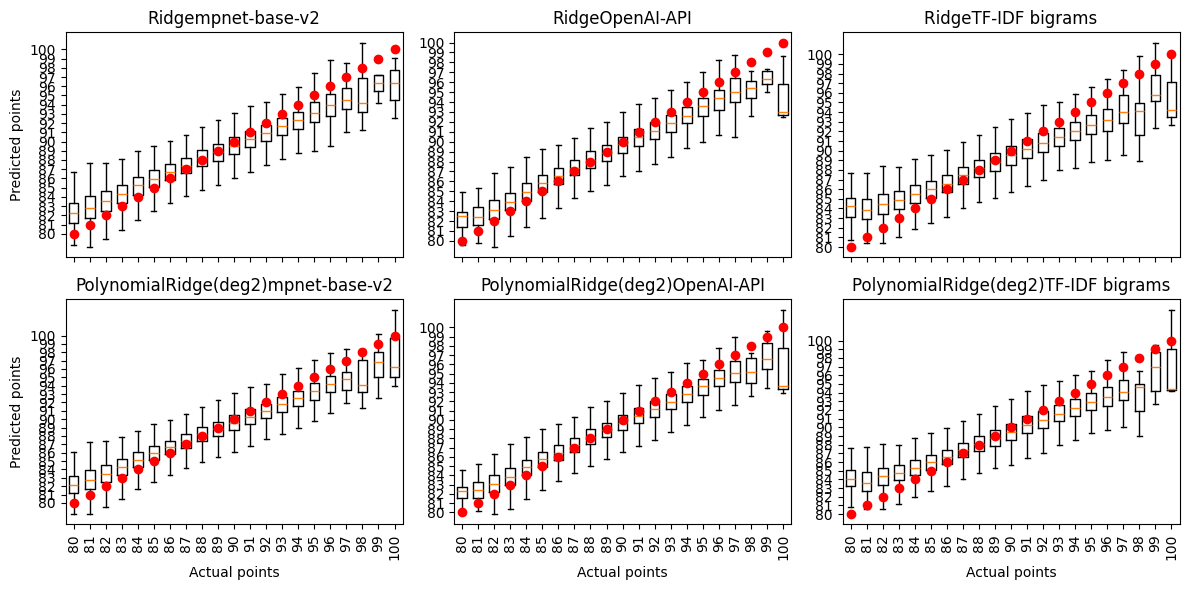

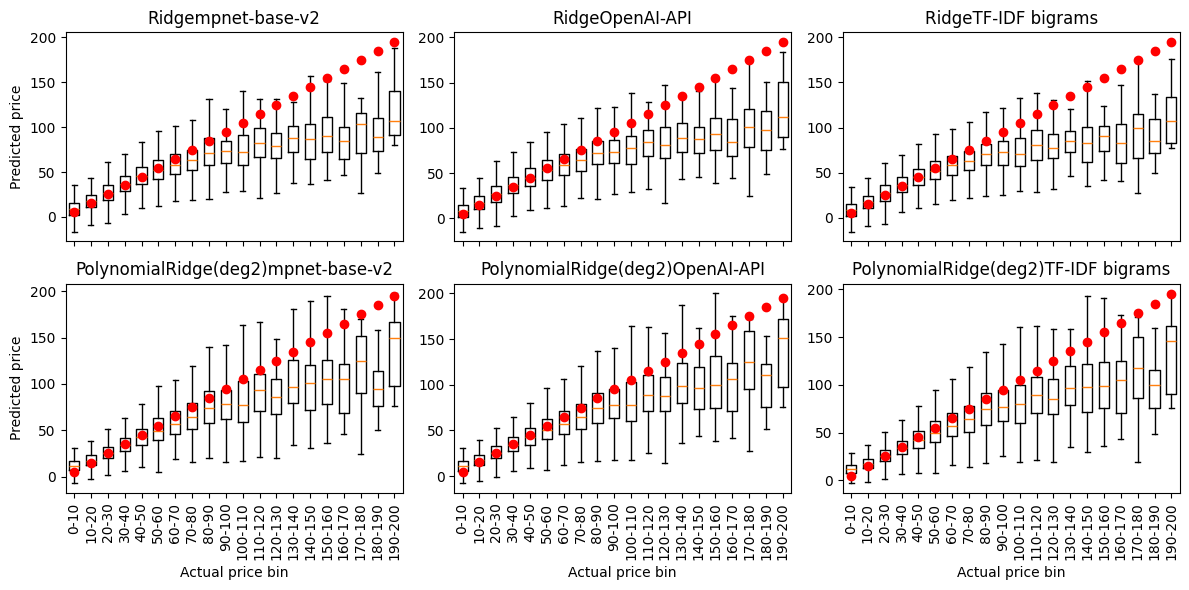

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Price plot range settings
PRICE_MIN = 0
PRICE_MAX = 200
PRICE_STEP = 10


def plot_predicted_vs_actual_boxplot(ax, y_test, y_pred, title=None):
    pred_vs_actual = pd.DataFrame({
        "points": y_test,
        "predicted_points": y_pred,
    })

    forced_points = list(range(80, 101))

    data = [
        pred_vs_actual.loc[pred_vs_actual["points"] == p, "predicted_points"]
        if (pred_vs_actual["points"] == p).any()
        else pd.Series(dtype=float)
        for p in forced_points
    ]

    ax.boxplot(
        data,
        positions=range(1, len(forced_points) + 1),
        widths=0.6,
        showfliers=False,
    )

    x_pos = {p: i + 1 for i, p in enumerate(forced_points)}
    xs = [x_pos[p] for p in forced_points]
    ys = forced_points
    ax.scatter(xs, ys, color="red", zorder=3, label="y = x (80-100)")

    ax.set_xticks(range(1, len(forced_points) + 1))
    ax.set_xticklabels(forced_points, rotation=90)
    ax.set_yticks(forced_points)
    ax.set_xlabel("Actual points")
    ax.set_ylabel("Predicted points")
    if title:
        ax.set_title(title)


def plot_predicted_vs_actual_price_bins(
    ax,
    y_test,
    y_pred,
    price_min,
    price_max,
    price_step,
    title=None,
):
    pred_vs_actual = pd.DataFrame({
        "actual_price": y_test,
        "predicted_price": y_pred,
    })

    pred_vs_actual = pred_vs_actual[
        (pred_vs_actual["actual_price"] >= price_min)
        & (pred_vs_actual["actual_price"] <= price_max)
    ]

    bins = np.arange(price_min, price_max + price_step, price_step)
    labels = [
        f"{int(bins[i])}-{int(bins[i + 1])}" for i in range(len(bins) - 1)
    ]
    pred_vs_actual["price_bin"] = pd.cut(
        pred_vs_actual["actual_price"],
        bins=bins,
        include_lowest=True,
        right=False,
        labels=labels,
    )

    data = [
        pred_vs_actual.loc[pred_vs_actual["price_bin"] == label, "predicted_price"]
        if (pred_vs_actual["price_bin"] == label).any()
        else pd.Series(dtype=float)
        for label in labels
    ]

    ax.boxplot(
        data,
        positions=range(1, len(labels) + 1),
        widths=0.6,
        showfliers=False,
    )

    # y = x reference using bin centers
    x_pos = list(range(1, len(labels) + 1))
    bin_centers = [(bins[i] + bins[i + 1]) / 2 for i in range(len(bins) - 1)]
    ax.scatter(x_pos, bin_centers, color="red", zorder=3, label="y = x (bin center)")

    ax.set_xticks(range(1, len(labels) + 1))
    ax.set_xticklabels(labels, rotation=90)
    ax.set_xlabel("Actual price bin")
    ax.set_ylabel("Predicted price")
    if title:
        ax.set_title(title)


def plot_boxplot_grid(predictions, regressions, embeddings, plot_fn):
    n_rows = len(regressions)
    n_cols = len(embeddings)

    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows), sharex=False, sharey=False
    )

    if n_rows == 1:
        axes = np.array([axes])
    if n_cols == 1:
        axes = axes.reshape(n_rows, 1)

    for i, reg in enumerate(regressions):
        for j, emb in enumerate(embeddings):
            ax = axes[i, j]
            key = (emb, reg)
            if key not in predictions:
                ax.axis("off")
                continue

            y_test, y_pred = predictions[key]
            plot_fn(
                ax,
                y_test,
                y_pred,
                title=f"{reg}{emb}",
            )

            if i < n_rows - 1:
                ax.set_xlabel("")
                ax.set_xticklabels([])
            if j > 0:
                ax.set_ylabel("")

    plt.tight_layout()
    plt.show()


for target_name in TARGETS:
    if target_name not in predictions_cache:
        print(f"No predictions for target: {target_name}")
        continue

    if target_name == "points":
        plot_boxplot_grid(
            predictions_cache[target_name],
            regression_order,
            embedding_order,
            plot_predicted_vs_actual_boxplot,
        )
    elif target_name == "price":
        plot_boxplot_grid(
            predictions_cache[target_name],
            regression_order,
            embedding_order,
            lambda ax, y_test, y_pred, title=None: plot_predicted_vs_actual_price_bins(
                ax,
                y_test,
                y_pred,
                PRICE_MIN,
                PRICE_MAX,
                PRICE_STEP,
                title=title,
            ),
        )
    else:
        print(f"No plot configured for target: {target_name}")
